In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cvx
from scipy.optimize import minimize

# plot styling
plt.style.use('seaborn-darkgrid') # style
plt.rcParams['font.family'] = ' DIN Alternate' # for macintosh use

GLOBAL_FONT_SIZE = 13 
plt.rcParams.update({'font.size': GLOBAL_FONT_SIZE}) # font size
plt_dpi = None # resolution

In [2]:
def visualize_stocks(data, task=None, ef_params={}, mv_params={}, sharpe_params={}):
    """ Plot method for mean-volatility diagrams """
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=data,
        hue='Stock',
        x='Volatility',
        y='Mean',
        s=100,
        zorder=10
    )

    plt.xlim([0, 8])
    plt.ylim([99, 102])
    
    ms = 150
    if mv_params != {}:
        plt.scatter(
            mv_params['vol'],
            mv_params['mean'],
            s=ms,
            marker='*',
            label='Minimum variance\nportfolio',
            color='red',
            zorder=10
        )

    if sharpe_params != {}:
        plt.scatter(
            sharpe_params['vol'],
            sharpe_params['mean'],
            s=ms,
            marker='*',
            label='Sharpe\nportfolio',
            color='purple',
            zorder=10
        )

    if ef_params != {}:
        plt.plot(
            ef_params['vol'],
            ef_params['mean'],
            label='Efficient frontier\n(w/ shorting)'
        )
        
    if 'vol_ns' in ef_params:
        plt.plot(
            ef_params['vol_ns'],
            ef_params['mean_ns'],
            label='Efficient frontier\n(w/o shorting)'
        )

        
    plt.legend(
        title='STOCKS',
        bbox_to_anchor=(1., 1.),
        ncol=2
    )

    plt.tight_layout()
    if task != None:
        plt.savefig(f'plots_CA4/{task}.png', dpi=plt_dpi, bbox_inches='tight')
    plt.show()

## Computer assignment 4
# Portfolio selection

## Task 1

In [3]:
# read data
prices = pd.read_csv('data/Dow_SP500_9620_weekly.csv', sep=';', index_col='Date')
prices.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,HD,IBM,INTC,...,NKE,PFE,PG,TRV,UNH,VZ,WBA,WMT,XOM,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
1996-01-12,0.259693,8.057922,23.880098,7.515189,2.873730,10.498715,15.032936,6.160898,12.851099,4.334345,...,3.293058,4.436570,11.208732,14.235675,5.896209,10.168702,5.141184,7.321432,9.170012,601.809998
1996-01-19,0.229028,8.858547,24.072062,7.628639,3.082267,10.773031,15.032936,6.214009,15.175826,3.932485,...,3.360140,4.463622,11.457310,14.714453,6.142966,10.224173,5.581854,6.539930,9.342753,611.830017
1996-01-26,0.234778,8.910208,23.572956,8.048859,3.300976,10.473772,15.220850,6.391046,15.584974,4.209958,...,3.366236,4.752178,11.473786,14.842113,6.441671,10.020799,5.623826,6.581063,9.184404,621.619995
1996-02-02,0.224237,9.245948,23.956888,8.194316,3.438303,10.523651,15.534036,6.444155,16.310287,4.347106,...,3.311352,4.896456,10.995718,14.491022,6.597519,10.187198,5.812685,7.074642,9.299567,635.840027
1996-02-09,0.212738,9.788308,25.456831,8.355942,3.712961,10.922656,15.721946,6.656601,16.923689,4.442858,...,3.317451,4.990697,11.572701,14.810210,6.701417,10.704880,5.980560,7.362564,9.603883,656.369995


In [4]:
# compute gross returns
pct_change = prices.pct_change().dropna()
gross_returns = 1 + pct_change
gross_returns.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,HD,IBM,INTC,...,NKE,PFE,PG,TRV,UNH,VZ,WBA,WMT,XOM,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
1996-01-19,0.881920,1.099359,1.008039,1.015096,1.072567,1.026129,1.000000,1.008621,1.180897,0.907285,...,1.020371,1.006098,1.022177,1.033632,1.041850,1.005455,1.085714,0.893258,1.018838,1.016650
1996-01-26,1.025107,1.005832,0.979266,1.055084,1.070957,0.972221,1.012500,1.028490,1.026961,1.070559,...,1.001814,1.064646,1.001438,1.008676,1.048626,0.980109,1.007519,1.006290,0.983051,1.016001
1996-02-02,0.955101,1.037680,1.016287,1.018072,1.041602,1.004762,1.020576,1.008310,1.046539,1.032577,...,0.983695,1.030361,0.958334,0.976345,1.024194,1.016605,1.033582,1.075000,1.012539,1.022876
1996-02-09,0.948718,1.058659,1.062610,1.019724,1.079882,1.037915,1.012097,1.032967,1.037608,1.022027,...,1.001842,1.019247,1.052473,1.022027,1.015748,1.050817,1.028881,1.040698,1.032724,1.032288
1996-02-16,0.990991,0.976254,0.987897,1.036750,0.975343,1.027417,1.021912,1.007979,1.039648,0.992457,...,0.988970,0.987296,0.981482,1.034483,1.007752,0.944731,0.975439,0.949720,0.986384,0.987218


### Compute moving average estimates

In [5]:
win_size = 100
rolling_mean_gross = gross_returns.rolling(window=win_size).mean()
rolling_mean_gross.columns = gross_returns.columns

In [6]:
win_size = 100
rolling_cov_gross = gross_returns.rolling(window=win_size).cov()
rolling_cov_gross.columns = gross_returns.columns

### Extract data for 101st week

In [7]:
week = 99
mean_w100 = rolling_mean_gross.iloc[week]
date = mean_w100.name # date in week 101

cov_w100 = rolling_cov_gross.loc[date]
std_w100 = np.sqrt(np.diag(cov_w100))

### 1a) Visualize stocks in Mean-Volatility diagram

In [8]:
# construct mean-volatilty table
v0 = 100
res = {
    'Stock': gross_returns.columns,
    'Mean': mean_w100 * v0,
    'Volatility': std_w100 * v0
}
mean_vol = pd.DataFrame(res).set_index('Stock')

In [9]:
# visualize stocks
# visualize_stocks(mean_vol.iloc[:-1])

### 1b) Visualize the efficient frontiers

In [10]:
# initial investment
v0 = 100

# number of stocks
n = mean_w100.shape[0] - 1

# compute mean vector
mu = mean_w100.values[:-1].reshape((n, 1))

# compute covariance
cov = cov_w100.values[:-1, :-1]

# compute volatilities
vol = np.diag(cov)

# compute inverse covariance
inv_cov = np.linalg.inv(cov)

# define unit vector
unit_vec = np.ones((n, 1))

# compute minimum variance portfolio
w_MV = (inv_cov @ unit_vec) / (unit_vec.T @ inv_cov @ unit_vec)
e_MV = (w_MV.T @ mu) * v0
vol_MV = np.sqrt((w_MV.T @ cov @ w_MV)) * v0

In [11]:
# minimum-varaince portfolio
mv_params = {
    'vol': vol_MV,
    'mean': e_MV
}

In [12]:
def get_efficient_frontier(mu, cov, e_0, v0):
    n = cov.shape[0]
    unit = np.ones((n, 1))
    inv_cov = np.linalg.inv(cov)
    A = unit.T @ inv_cov @ unit
    B = unit.T @ inv_cov @ mu
    C = mu.T @ inv_cov @ mu
    D = A * C - np.square(B)
    lbd_1 = (A * e_0 - B * v0) / D
    lbd_2 = (C * v0 - B * e_0) / D
    w = lbd_1 * (inv_cov @ mu) + lbd_2 * (inv_cov @ unit)
    w = w.reshape((e_0.shape[0], n))
    mean = w @ mu
    vol = np.sqrt(np.diag(w @ cov @ w.T))
    return vol, mean

In [13]:
# compute efficient frontier
e_0 = np.linspace(e_MV - 2, e_MV + 2, 250)
vol_ef, mean_ef = get_efficient_frontier(mu, cov, e_0, v0)
ef_params = {
    'vol': vol_ef,
    'mean': mean_ef
}

In [14]:
# visualize_stocks(mean_vol[:-1], ef_params=ef_params)

### 1c) Compute Sharpe portfolio

#### Shorting allowed

In [15]:
# compute optimal allocation
w_SR = (inv_cov @ (mu - unit_vec)) / (unit_vec.T @ inv_cov @ (mu - unit_vec))

In [16]:
# compute expectation and volatility of Shaprpe portfolio
e_SR = (w_SR.T @ mu) * v0
vol_SR = np.sqrt(w_SR.T @ cov @ w_SR) * v0
sharpe_params = {
    'mean': e_SR,
    'vol': vol_SR
}

In [17]:
# visualize_stocks(
#     mean_vol[:-1],
#     ef_params=ef_params,
#     sharpe_params=sharpe_params
# )

#### Shorting NOT allowed

In [18]:
# initial investment
v0 = 100

# number of stocks
n = mean_w100.shape[0] - 1

# compute mean vector
mu = mean_w100.values[:-1].reshape((n, 1))

# compute covariance
cov = cov_w100.values[:-1, :-1]

# compute volatilities
vol = np.diag(cov)

# compute inverse covariance
inv_cov = np.linalg.inv(cov)

# define unit vector
unit = np.ones((n, 1))

In [19]:
# find efficient frontier without shorting
e_0 = np.linspace(99, 102, 500)
N = e_0.shape[0]
w_mat = np.zeros((N, n))
for i in np.arange(N):
    # CONVEX OPTIMIZATION PROBLEM
    w = cvx.Variable(n)
    objective_func = cvx.quad_form(w, cov)
    constraints = [
        w @ unit == v0, # fully invested
        w @ mu == e_0[i], # varying returns
        w >= 0 # no short positions
    ]
    minimize = cvx.Minimize(objective_func)
    problem = cvx.Problem(minimize, constraints)
    problem.solve()
    w_mat[i] = w.value

In [20]:
# compute mean and volatility without shorting
mean_ns = w_mat @ mu
vol_ns = np.sqrt(np.diag(w_mat @ cov @ w_mat.T))
ef_params['vol_ns'] = vol_ns
ef_params['mean_ns'] = mean_ns

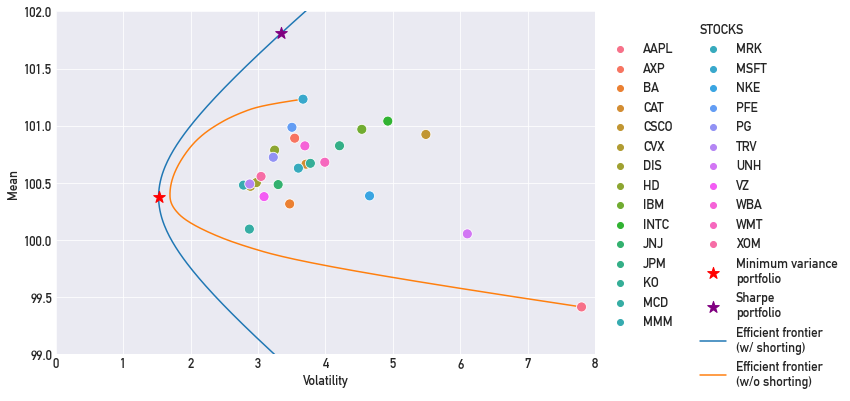

In [21]:
visualize_stocks(
    data=mean_vol[:-1],
    task='1c',
    ef_params=ef_params,
    mv_params=mv_params,
    sharpe_params=sharpe_params
)

### 1d) Plot the Sharpe allocation

In [22]:
sharpe_tab = {
    'Stock': mean_vol.index[:-1],
    'Allocation': w_SR.flatten() * v0
}
sharpe_allocation = pd.DataFrame(sharpe_tab).set_index('Stock')

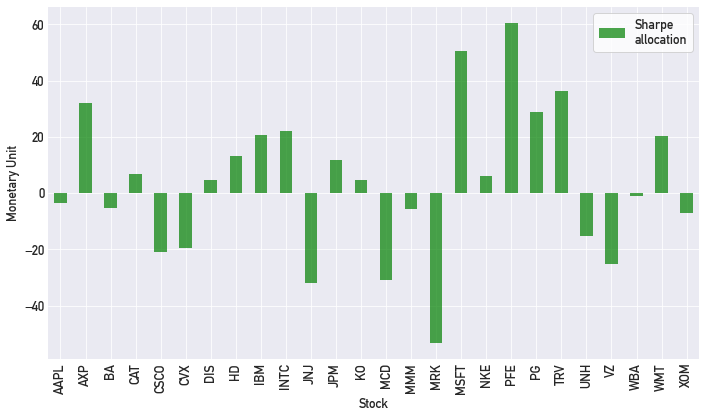

In [23]:
sharpe_allocation.plot.bar(
    figsize=(10, 6),
    color='green',
    alpha=.7
)
plt.legend(labels=['Sharpe\nallocation'], frameon=1, facecolor='white')
plt.ylabel('Monetary Unit')
plt.tight_layout()
plt.savefig('plots_CA4/1d.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

### 1e) Plot the gross return correlation as heatmap

In [24]:
# compute correlation matric
# win_size = 100
# rolling_corr_gross = gross_returns.rolling(window=win_size).corr()
# rolling_corr_gross.columns = gross_returns.columns
# corr_w100 = rolling_corr_gross.loc[date]
# corr = corr_w100.iloc[:-1, :-1]
corr = gross_returns.iloc[:-1, :-1].corr()

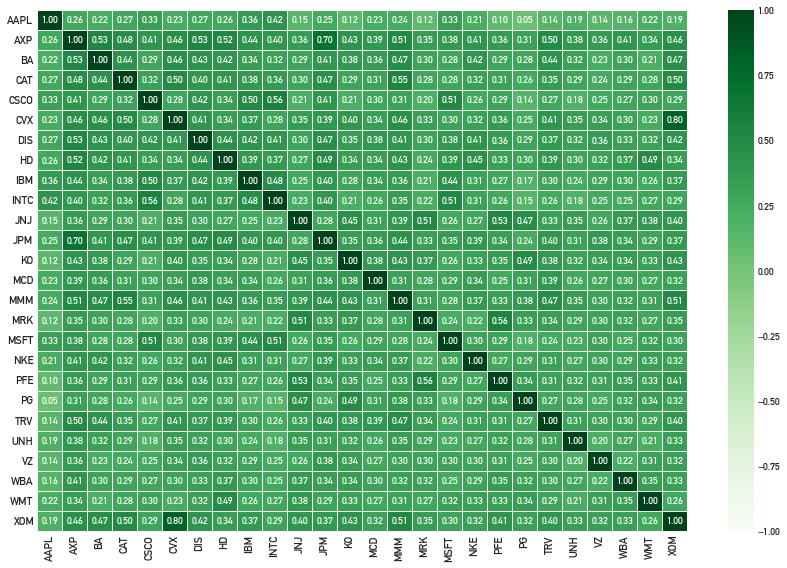

In [25]:
_, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['font.size'] = 10 # decrease font size
ax = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    cmap='Greens',
    annot=True,
    fmt='.2f', 
    linewidths=.5,
    ax=ax,
    annot_kws={'color': 'white'}
)
ax.xaxis.set_tick_params(labelsize=11) # change tick label sizes
ax.yaxis.set_tick_params(labelsize=11) # change tick label sizes
plt.savefig('plots_CA4/1e.png', dpi=plt_dpi, bbox_inches='tight')
plt.tight_layout()
plt.rcParams['font.size'] = GLOBAL_FONT_SIZE # reset font size

## Task 2

In [26]:
def get_allocation(mu, cov, mu_0, v):
    n = cov.shape[0]
    unit = np.ones((n, 1))
    inv_cov = np.linalg.inv(cov)
    A = unit.T @ inv_cov @ unit
    B = unit.T @ inv_cov @ mu
    C = mu.T @ inv_cov @ mu
    D = A * C - np.square(B)
    lbd_1 = (A * mu_0 * v - B * v) / D
    lbd_2 = (C * v - B * mu_0 * v) / D
    w = lbd_1 * (inv_cov @ mu) + lbd_2 * (inv_cov @ unit)
    return w

In [27]:
def get_allocation_NS(mu, cov, mu_0, v):
    """ Target portfolio allocation - no shorting """
    n = cov.shape[0]
    unit = np.ones((n, 1))
    w = cvx.Variable(shape=(n, 1), name='w')
    objective_func = cvx.quad_form(w, cov)
    constraints = [
        w.T @ unit == v, # fully invested
        w.T @ mu == v * mu_0, # varying target return
        w >= 0.0 # no short positions
    ]
    minimize = cvx.Minimize(objective_func)
    problem = cvx.Problem(minimize, constraints)
    problem.solve()

    # if no solution is found
    if w.value is None:
        mu = mu.flatten()
        if mu_0 <= np.mean(mu):
            idx = mu == np.min(mu)
        else:
            idx = mu == np.max(mu)
        w = np.zeros(n)
        w[idx] = v
        return w
    return w.value

In [28]:
def get_ENC(w):
    w = w / np.sum(w)
    return 1 / np.sum(np.square(w))

### Backtesting

In [29]:
# backtesting rolling means
week = 99
mu_bt = rolling_mean_gross.iloc[week:]
mu_bt = mu_bt.values.reshape(
    (mu_bt.shape[0], mu_bt.shape[1], 1)
)
mu_bt = mu_bt[:, :-1]

# backtesting gross returns
returns_bt = gross_returns.iloc[week:]
returns_bt = returns_bt.values.reshape(
    (returns_bt.shape[0], returns_bt.shape[1], 1)
)
returns_bt = returns_bt[:, :-1]

# backtesting rolling covariance
date = rolling_mean_gross.iloc[week].name
cov_bt = rolling_cov_gross.loc[date:]
cov_bt = cov_bt.values.reshape(
    (int(cov_bt.shape[0] / cov_bt.shape[1]), cov_bt.shape[1], cov_bt.shape[1])
)
cov_bt = cov_bt[:, :-1, :-1]

In [30]:
# backtesting rolling means
week = 99
mu_bt = rolling_mean_gross.iloc[week:]
mu_bt = mu_bt.values.reshape(
    (mu_bt.shape[0], mu_bt.shape[1], 1)
)
mu_bt = mu_bt[:, :-1]

# backtesting gross returns
returns_bt = gross_returns.iloc[week:]
returns_bt = returns_bt.values.reshape(
    (returns_bt.shape[0], returns_bt.shape[1], 1)
)
returns_bt = returns_bt[:, :-1]

# backtesting rolling covariance
date = rolling_mean_gross.iloc[week].name
cov_bt = rolling_cov_gross.loc[date:]
cov_bt = cov_bt.values.reshape(
    (int(cov_bt.shape[0] / cov_bt.shape[1]), cov_bt.shape[1], cov_bt.shape[1])
)
cov_bt = cov_bt[:, :-1, :-1]

#### Shorting allowed

In [31]:
# shorting allowed
T = cov_bt.shape[0] - 1
e_short = np.zeros(T)
ENC_short = np.zeros(T)
w_short = np.zeros((T, n, 1))

v = 100.0 # initial investment
mu_0 = 1.00275
for t in np.arange(T):
    mu_bt_t = mu_bt[t]
    cov_bt_t = cov_bt[t]
    w = get_allocation(mu_bt_t, cov_bt_t, mu_0, v)
    v = (w.T @ returns_bt[t + 1]).flatten()
    e_short[t] = v
    ENC_short[t] = get_ENC(w)
    w_short[t] = w / np.sum(w)

#### Shorting not allowed

In [32]:
# no shorting allowed
T = cov_bt.shape[0] - 1
e_no_short = np.zeros(T)
ENC_no_short = np.zeros(T)
w_no_short = np.zeros((T, n))

v = 100.0 # initial investment
mu_0 = 1.00275
for t in np.arange(T):
    mu_bt_t = mu_bt[t]
    cov_bt_t = cov_bt[t]
    w = get_allocation_NS(mu_bt_t, cov_bt_t, mu_0, v)
    v = (w.T @ returns_bt[t + 1]).flatten()
    e_no_short[t] = v
    ENC_no_short[t] = get_ENC(w)
    w_no_short[t] = w.flatten() / np.sum(w)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


#### Equal weight portfolio

In [33]:
# equal weight portfolio
T = cov_bt.shape[0] - 1
n = cov_bt.shape[1]
e_ew = np.zeros(T)
ENC_ew = np.zeros(T)
w_ew = np.zeros((T, n))

v = 100.0 # initial investment
w = np.ones((1, n)) * (v / n)
for t in np.arange(T):
    v = w @ returns_bt[t + 1]
    e_ew[t] = v
    w = np.ones((1, n)) * (v / n)
    w_ew[t] = w.flatten() / np.sum(w)
    ENC_ew[t] = get_ENC(w)

### 2a) Plot portfolio evolution

In [34]:
res = {
    'Week': np.arange(T),
    'Target portfolio\n(w/ shorting)': e_short,
    'Target portfolio\n(w/o shorting)': e_no_short,
    'Equal weight portfolio': e_ew
}
res_2a = pd.DataFrame(res).set_index('Week')

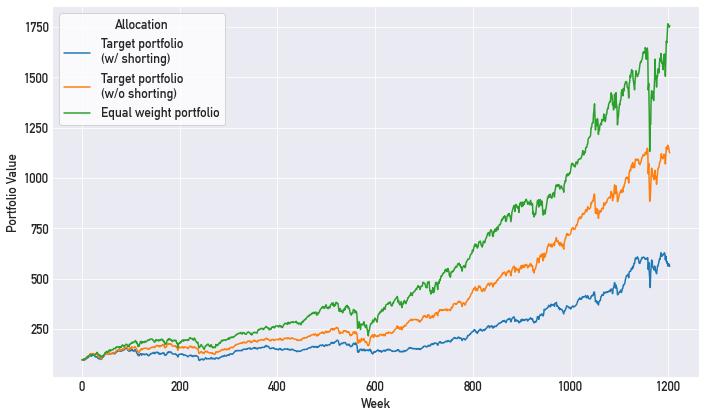

In [35]:
res_2a.plot(figsize=(10, 6))
plt.ylabel('Portfolio Value')
plt.legend(frameon=1, facecolor='white', title='Allocation')
plt.tight_layout()
plt.savefig('plots_CA4/2a.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

### 2b) Create table of portfolio values beginning at every 100th week (start at week 0)

In [36]:
idx = res_2a.index % 100 == 0
res_2b = res_2a.iloc[idx].round(2)
res_2b

,Target portfolio\n(w/ shorting),Target portfolio\n(w/o shorting),Equal weight portfolio
Week,,,
0,96.75,97.44,98.02
100,143.44,156.29,178.31
200,124.64,158.20,180.02
300,122.77,152.78,205.76
400,150.05,198.83,266.45
500,170.82,238.92,368.50
600,135.18,217.30,303.58
700,165.28,317.30,479.40
800,238.67,443.57,635.07


In [37]:
# for report use - 2b)
res_2b_latex = res_2b.to_latex(
    position='H',
    label='tab:2b',
    caption='Caption'
)
print(res_2b_latex)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:2b}
\begin{tabular}{lrrr}
\toprule
{} &  Target portfolio\textbackslash n(w/ shorting) &  Target portfolio\textbackslash n(w/o shorting) &  Equal weight portfolio \\
Week &                                  &                                   &                         \\
\midrule
0    &                            96.75 &                             97.44 &                   98.02 \\
100  &                           143.44 &                            156.29 &                  178.31 \\
200  &                           124.64 &                            158.20 &                  180.02 \\
300  &                           122.77 &                            152.78 &                  205.76 \\
400  &                           150.05 &                            198.83 &                  266.45 \\
500  &                           170.82 &                            238.92 &                  368.50 \\
600  &                           

### 2c) Calculate annualized means, volatilities, Sharpe ratios, maximum drawdown and average ENCs for the portfolios’ weekly percentage returns over the backtesting period

In [38]:
def get_sharpe(e):
    R = (e[1:] / e[:-1]) - 1
    return np.sqrt(52.0) * np.mean(R) / np.std(R)

In [39]:
def get_annualized_mean(e):
    returns = (e[1:] / e[:-1]) - 1
    return np.mean(returns) * 52.0

In [40]:
def get_annualized_volatility(e):
    returns = (e[1:] / e[:-1]) - 1
    return np.std(returns) * np.sqrt(52.0)

In [41]:
def get_annualized_ENC(ENC):
    return np.mean(ENC)

In [42]:
def get_MD(e):
    CM = np.maximum.accumulate(e)
    DD = CM - e
    return np.max(DD / CM)

In [43]:
# define portfolio lists
portfolio_labels = [
    'Target Portfolio (w/ shorting)',
    'Target Portfolio (w/o shorting)',
    'Equal Weight Portfolio'
]
portfolios = [e_short, e_no_short, e_ew]
ENCs = [ENC_short, ENC_no_short, ENC_ew]

# create dict and df
res = {
    'Portfolio': portfolio_labels,
    'Mean': [get_annualized_mean(e) for e in portfolios],
    'Volatility': [get_annualized_volatility(e) for e in portfolios],
    'Sharpe Ratio': [get_sharpe(e) for e in portfolios],
    'MDD': [get_MD(e) for e in portfolios],
    'Average ENC': [get_annualized_ENC(ENC) for ENC in ENCs]   
}
df_2c = pd.DataFrame(res).set_index('Portfolio').round(4)

# print results
df_2c

,Mean,Volatility,Sharpe Ratio,MDD,Average ENC
Portfolio,,,,,
Target Portfolio (w/ shorting),0.0888,0.1593,0.5577,0.4063,2.9539
Target Portfolio (w/o shorting),0.1174,0.1509,0.7778,0.3492,5.9738
Equal Weight Portfolio,0.1403,0.1749,0.8021,0.4354,26.0000


In [44]:
# for report use - 2c)
caption = 'Caption'
res_2c = df_2c.to_latex(position='H', caption=caption, label='tab:2c')
print(res_2c)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:2c}
\begin{tabular}{lrrrrr}
\toprule
{} &    Mean &  Volatility &  Sharpe Ratio &     MDD &  Average ENC \\
Portfolio                       &         &             &               &         &              \\
\midrule
Target Portfolio (w/ shorting)  &  0.0888 &      0.1593 &        0.5577 &  0.4063 &       2.9539 \\
Target Portfolio (w/o shorting) &  0.1174 &      0.1509 &        0.7778 &  0.3492 &       5.9738 \\
Equal Weight Portfolio          &  0.1403 &      0.1749 &        0.8021 &  0.4354 &      26.0000 \\
\bottomrule
\end{tabular}
\end{table}



### 2d) Plot the portfolio percentage weights for the no short target portfolio using the area plot

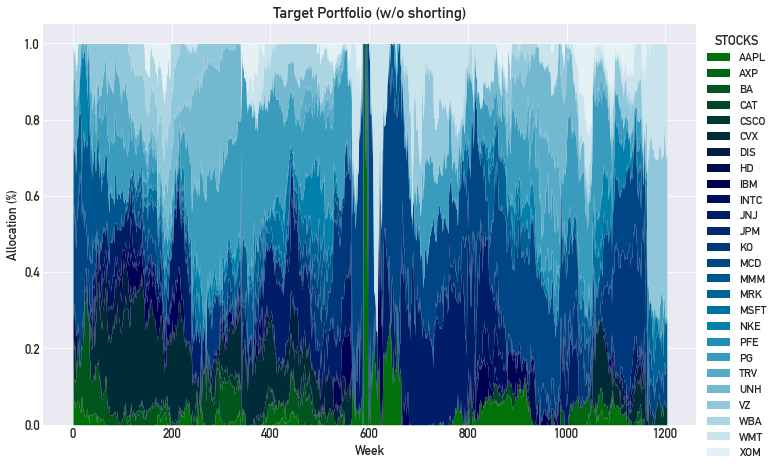

In [45]:
w_df = pd.DataFrame(w_no_short.reshape((T, n)))
w_df.columns = gross_returns.columns[:-1]
w_df[w_df < 0.0] = 0.0 # remove zeros
w_df.plot.area(
    figsize=(11, 7),
    stacked=True,
    lw=0,
    color=sns.color_palette('ocean', n_colors=n)
)
plt.legend(title='STOCKS', bbox_to_anchor=(1., 1.), fontsize=11.5)
plt.ylabel('Allocation (%)')
plt.xlabel('Week')
plt.title('Target Portfolio (w/o shorting)')
plt.tight_layout()
plt.savefig('plots_CA4/2d.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

## Task 3

In [46]:
def get_w(mu, inv_cov, mu0, R0, v0, w_h):
    n = inv_cov.shape[0]
    unit = np.ones((n, 1))
    upper = (mu0 - R0) * v0 - w_h.T @ (mu - (R0 * unit))
    lower = (mu - (R0 * unit)).T @ inv_cov @ (mu - (R0 * unit))
    w = upper / lower * (inv_cov @ (mu - (R0 * unit))) + w_h
    return w

In [47]:
def get_tracking_error(var_index, var_port, sigma_LR, w_port):
    return var_port - 2 * w_port.T @ sigma_LR + var_index

In [48]:
def get_optimal_portfolio(mu, cov, mu0, R0, sigma_LR, v0):
    inv_cov = np.linalg.inv(cov)
    w_h = inv_cov @ sigma_LR
    w = get_w(mu, inv_cov, mu0, R0, v0, w_h)
    return w, w_h

In [49]:
def get_efficient_frontier_mean_track(mu, cov, R0, sigma_LR, v0, var_index):
    mu0 = np.linspace(99, 102, 1000) / 100.0
    N = mu0.shape[0]
    n = cov.shape[0]
    W = np.zeros((N, n, 1))
    E, vol, error = np.zeros((N, 1)), np.zeros((N, 1)), np.zeros((N, 1))
    inv_cov = np.linalg.inv(cov)
    w_h = inv_cov @ sigma_LR
    for i in np.arange(N):
        W[i] = get_w(mu, inv_cov, mu0[i], R0, v0, w_h)
        E[i] = W[i].T @ mu
        vol[i] = np.sqrt(np.diag(W[i].T @ cov @ W[i]))
        error[i] = get_tracking_error(
            var_index, np.square(vol[i]), sigma_LR, W[i]
        )
    return vol, E, W, error

In [50]:
# fetch data
R0 = 1.0
L0, v0 = 100.0, 100.0

# parameter estimates
last_returns = rolling_mean_gross.iloc[-1]
last_date = last_returns.name
last_cov = rolling_cov_gross.loc[last_date]

mu0 = last_returns[-1] # index return
mu_vec = last_returns[:-1].values.reshape((26,1)) # stock returns

sigma_LR = last_cov.iloc[-1, :-1].values.reshape((26, 1)) * L0 # covariance between index and each stock
sigma = last_cov.iloc[:-1, :-1].values # covariance matrix for stocks
var_SP500 = last_cov.iloc[-1, -1] * np.square(L0)

In [51]:
# backtesting rolling means
week = 99
mu_bt = rolling_mean_gross.iloc[week:]
mu_bt = mu_bt.values.reshape(
    (mu_bt.shape[0], mu_bt.shape[1], 1)
)
mu_bt = mu_bt[:, :-1]

# backtesting gross returns
returns_bt = gross_returns.iloc[week:]
returns_bt = returns_bt.values.reshape(
    (returns_bt.shape[0], returns_bt.shape[1], 1)
)
returns_bt = returns_bt[:, :-1]

# backtesting rolling covariance
date = rolling_mean_gross.iloc[week].name
cov_bt = rolling_cov_gross.loc[date:]
cov_bt = cov_bt.values.reshape(
    (int(cov_bt.shape[0] / cov_bt.shape[1]), cov_bt.shape[1], cov_bt.shape[1])
)
cov_bt = cov_bt[:, :-1, :-1]

In [52]:
last_returns.index

Index(['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'HD', 'IBM', 'INTC',
       'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG',
       'TRV', 'UNH', 'VZ', 'WBA', 'WMT', 'XOM', '^GSPC'],
      dtype='object')

### 3a) Plot the optimal hedge portfolio allocation as a bar plot and include the values in a table

In [53]:
_, w_h = get_optimal_portfolio(mu_vec, sigma, mu0, R0, sigma_LR, v0)

In [54]:
res_3a = {
    'Stock': last_returns.index[:-1],
    'Allocation': w_h.flatten()
}

bm_allocation = pd.DataFrame(res_3a).set_index('Stock')

In [55]:
bm_allocation.shape

(26, 1)

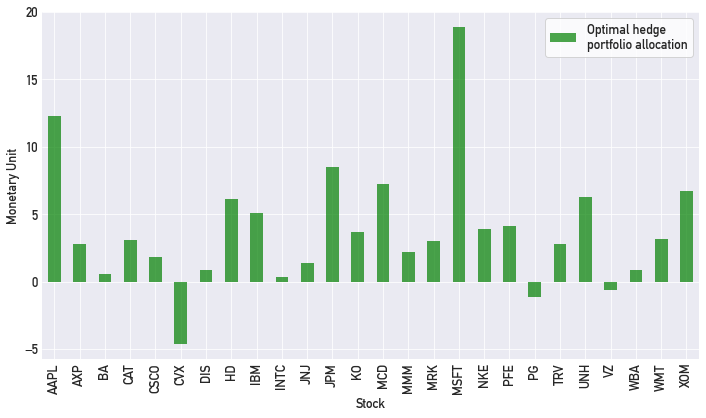

In [56]:
bm_allocation.plot.bar(
    figsize=(10, 6),
    color='green',
    alpha=.7
)
plt.legend(labels=['Optimal hedge\nportfolio allocation'], frameon=1, facecolor='white')
plt.ylabel('Monetary Unit')
plt.tight_layout()
plt.savefig('plots_CA4/3a.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

In [57]:
# for report use - 3a)
latex_3a_1 = bm_allocation.iloc[:13].T.round(2).to_latex(position='H', caption='Caption.', label='tab:3a_1')
print(latex_3a_1)

latex_3a_2 = bm_allocation.iloc[13:].T.round(2).to_latex(position='H', caption='Caption.', label='tab:3a_2')
print(latex_3a_2)

\begin{table}[H]
\centering
\caption{Caption.}
\label{tab:3a_1}
\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
Stock &   AAPL &   AXP &    BA &  CAT &  CSCO &   CVX &   DIS &    HD &   IBM &  INTC &   JNJ &   JPM &    KO \\
\midrule
Allocation &  12.29 &  2.79 &  0.55 &  3.1 &   1.8 & -4.59 &  0.87 &  6.11 &  5.11 &  0.35 &  1.41 &  8.54 &  3.69 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{Caption.}
\label{tab:3a_2}
\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
Stock &   MCD &  MMM &   MRK &   MSFT &   NKE &   PFE &    PG &   TRV &   UNH &    VZ &   WBA &   WMT &   XOM \\
\midrule
Allocation &  7.26 &  2.2 &  3.02 &  18.85 &  3.93 &  4.09 & -1.15 &  2.82 &  6.25 & -0.59 &  0.84 &  3.16 &  6.69 \\
\bottomrule
\end{tabular}
\end{table}



### 3b) Plot the “mean – tracking error” efficient frontier

In [58]:
vol, mean, W, error = get_efficient_frontier_mean_track(
    mu_vec, sigma, R0, sigma_LR, v0, var_SP500
)

In [59]:
hedge_e = w_h.T @ mu_vec
hedge_vol = np.sqrt(w_h.T @ sigma @ w_h)
hedge_error = get_tracking_error(var_SP500, np.square(hedge_vol), sigma_LR, w_h)

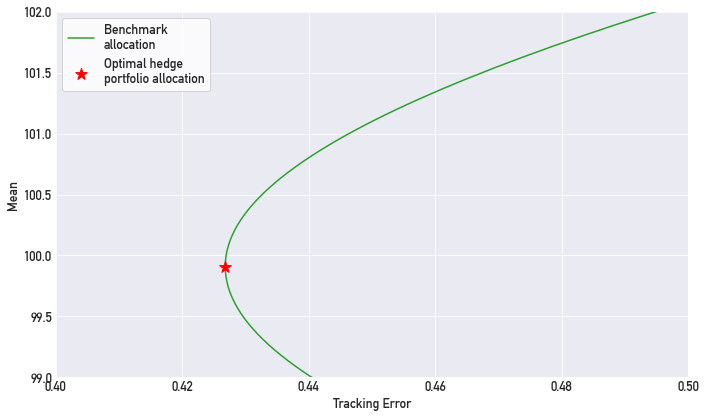

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(error), mean, label='Benchmark\nallocation', color=sns.color_palette()[2])
plt.scatter(
    np.sqrt(hedge_error), hedge_e, marker='*', zorder=10, color='red', s=150, label='Optimal hedge\nportfolio allocation'
)
plt.ylim([99, 102])
plt.xlim([0.4, 0.5])
plt.xlabel('Tracking Error')
plt.ylabel('Mean')
plt.legend(frameon=1, facecolor='white')
plt.tight_layout()
plt.savefig('plots_CA4/3b.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

### 3c) What is the smallest tracking error that can be achieved?

In [61]:
print('Minimum tracking error:', np.sqrt(np.min(error)).round(3))

Minimum tracking error: 0.427


### 3d) What is the expected excess return (in excess of S&P500) of the minimum tracking error portfolio?

In [62]:
excess_return = (hedge_e - (mu0 * 100)) / 100
print('Expected excess return:', excess_return.flatten()[0].round(4), '%')

Expected excess return: -0.0047 %


## Task 4

In [63]:
def cov2cor(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [64]:
def upper_tri_masking(A):
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:, None] < r
    return A[mask]

In [65]:
def get_allocation_sharpe(mu, cov):
    """ Sharpe portfolio allocation - no shorting """
    n = cov.shape[0]
    w = cvx.Variable(shape=(n, 1), name='w')
    objective_func = cvx.quad_form(w, cov)
    constraints = [
        mu.T @ w == 1.0,
        w >= 0.0
    ]
    minimize = cvx.Minimize(objective_func)
    problem = cvx.Problem(minimize, constraints)
    problem.solve()
    return w.value

#### Shrinkage (F = average correlation)

In [66]:
def shrink_cov(cov, alpha=0.3):
    vol = np.diag(np.sqrt(np.diag(cov)))
    cor = cov2cor(cov)
    mean_cor = np.mean(upper_tri_masking(cor))
    F_cor = np.eye(n)
    F_cor[F_cor == 0.0] = mean_cor
    F_cov = vol @ F_cor @ vol
    return (1.0 - alpha) * cov + alpha * F_cov

In [67]:
def shrink_mu(mu):
    # e = np.linalg.eigvals(cov)
    # e = np.flip(np.sort(e)) # sort descending
    # nom = np.sum(e) - 2 * e[0]
    # denom = (mu - grand_mean).T @ (mu - grand_mean)
    # alpha = (nom / denom) / T
    
    n = mu.shape[0]
    grand_mean = np.mean(mu) * np.ones((n, 1))
    alpha = 0.3
    return (1.0 - alpha) * mu + alpha * grand_mean

In [68]:
def denoise(cov, T=100.0):
    n = cov.shape[0]
    q = n / T
    e_lim = 1 + q + 2 * np.sqrt(q)
    vol = np.diag(np.sqrt(np.diag(cov)))
    cor = cov2cor(cov)
    e, v = np.linalg.eig(cor)

    # sort descending
    idx = np.flip(e.argsort())
    e = e[idx]
    v = v[:, idx]
     
    if np.sum(e > e_lim) == 0:
        e[1:] = np.mean(e[1:])
    else:
        e[e < e_lim] = np.mean(e[e < e_lim])

    cor_d = v @ np.diag(e) @ v.T
    cov_d = vol @ cor_d @ vol
    return cov_d

#### Fetch backtesting data

In [69]:
# backtesting rolling gross means
week = 99
mu_bt = rolling_mean_gross.iloc[week:]
mu_bt = mu_bt.values.reshape(
    (mu_bt.shape[0], mu_bt.shape[1], 1)
)
mu_bt = mu_bt[:, :-1]

# backtesting gross returns
returns_bt = gross_returns.iloc[week:]
returns_bt = returns_bt.values.reshape(
    (returns_bt.shape[0], returns_bt.shape[1], 1)
)
returns_bt = returns_bt[:, :-1]

# backtesting rolling gross return covariance
date = rolling_mean_gross.iloc[week].name
cov_bt = rolling_cov_gross.loc[date:]
cov_bt = cov_bt.values.reshape(
    (int(cov_bt.shape[0] / cov_bt.shape[1]), cov_bt.shape[1], cov_bt.shape[1])
)
cov_bt = cov_bt[:, :-1, :-1]

### 4a)

In [70]:
# Sharpe - no shorting allowed
T = cov_bt.shape[0] - 1
e_sharpe = np.zeros(T)
ENC_sharpe = np.zeros(T)
w_sharpe = np.zeros((T, n))

v = 100.0 # initial investment
for t in np.arange(T):
    w = get_allocation_sharpe(
        mu_bt[t] - 1.0,
        cov_bt[t]
    )
    w = w / np.sum(w) # normalize
    v = v * (w.T @ returns_bt[t + 1]).flatten()
    e_sharpe[t] = v
    ENC_sharpe[t] = get_ENC(w)
    w_sharpe[t] = w.flatten()

In [71]:
# Sharpe - no shorting allowed + shrinkage
T = cov_bt.shape[0] - 1
e_sharpe_s = np.zeros(T)
ENC_sharpe_s = np.zeros(T)
w_sharpe_s = np.zeros((T, n))

v = 100.0 # initial investment
for t in np.arange(T):
    cov_bt_t = cov_bt[t]
    w = get_allocation_sharpe(
        shrink_mu(mu_bt[t]) - 1.0,
        shrink_cov(cov_bt_t)
    )
    w = w / np.sum(w) # normalize
    v = v * (w.T @ returns_bt[t + 1]).flatten()
    e_sharpe_s[t] = v
    ENC_sharpe_s[t] = get_ENC(w)
    w_sharpe_s[t] = w.flatten()

In [72]:
# Sharpe - no shorting allowed + shrinkage (mu) + denoising (cov)
T = cov_bt.shape[0] - 1
e_sharpe_d = np.zeros(T)
ENC_sharpe_d = np.zeros(T)
w_sharpe_d = np.zeros((T, n))

v = 100.0 # initial investment
for t in np.arange(T):
    cov_bt_t = cov_bt[t]
    w = get_allocation_sharpe(
        shrink_mu(mu_bt[t]) - 1.0,
        denoise(cov_bt_t)
    )
    w = w / np.sum(w) # normalize
    v = v * (w.T @ returns_bt[t + 1]).flatten()
    e_sharpe_d[t] = v
    ENC_sharpe_d[t] = get_ENC(w)
    w_sharpe_d[t] = w.flatten()

In [73]:
res = {
    'Week': np.arange(T),
    'Target portfolio\n(w/ shorting)': e_short,
    'Target portfolio\n(w/o shorting)': e_no_short,
    'Equal weight portfolio': e_ew,
    'Sharpe portfolio': e_sharpe,
    'Sharpe portfolio (shrinkage)': e_sharpe_s,
    'Sharpe portfolio (denoising)': e_sharpe_d
}
res_4a = pd.DataFrame(res).set_index('Week')

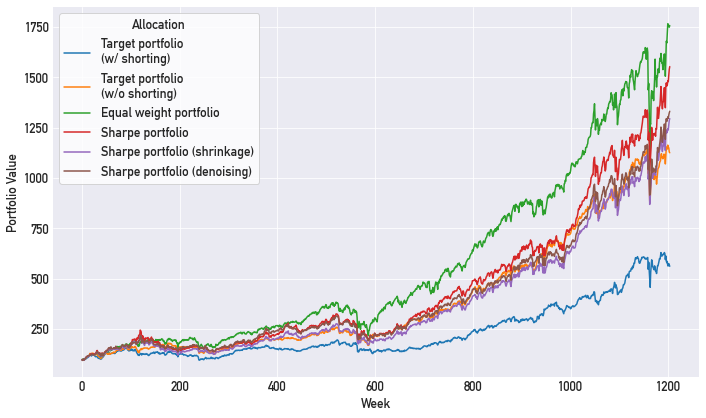

In [74]:
res_4a.plot(figsize=(10, 6))
plt.ylabel('Portfolio Value')
plt.legend(frameon=1, facecolor='white', title='Allocation')
plt.tight_layout()
plt.savefig('plots_CA4/4a.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

### 4b)

In [75]:
idx = res_4a.index % 100 == 0
res_4b = res_4a.iloc[idx].round(2)
res_4b

,Target portfolio\n(w/ shorting),Target portfolio\n(w/o shorting),Equal weight portfolio,Sharpe portfolio,Sharpe portfolio (shrinkage),Sharpe portfolio (denoising)
Week,,,,,,
0,96.75,97.44,98.02,96.58,96.57,95.85
100,143.44,156.29,178.31,177.97,169.68,168.63
200,124.64,158.20,180.02,145.75,136.14,154.56
300,122.77,152.78,205.76,161.34,147.02,163.16
400,150.05,198.83,266.45,226.69,204.59,244.08
500,170.82,238.92,368.50,296.76,251.52,286.02
600,135.18,217.30,303.58,222.30,195.45,220.93
700,165.28,317.30,479.40,336.70,289.36,317.93
800,238.67,443.57,635.07,489.30,413.05,446.31


In [76]:
# for report use - 5b)
res_4b_latex = res_4b.to_latex(
    position='H',
    label='tab:4b',
    caption='Caption'
)
print(res_4b_latex)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:4b}
\begin{tabular}{lrrrrrr}
\toprule
{} &  Target portfolio\textbackslash n(w/ shorting) &  Target portfolio\textbackslash n(w/o shorting) &  Equal weight portfolio &  Sharpe portfolio &  Sharpe portfolio (shrinkage) &  Sharpe portfolio (denoising) \\
Week &                                  &                                   &                         &                   &                               &                               \\
\midrule
0    &                            96.75 &                             97.44 &                   98.02 &             96.58 &                         96.57 &                         95.85 \\
100  &                           143.44 &                            156.29 &                  178.31 &            177.97 &                        169.68 &                        168.63 \\
200  &                           124.64 &                            158.20 &                  180.02 &           

### 4c)

In [77]:
# define portfolio lists
portfolio_labels = [
    'Sharpe portfolio',
    'Sharpe portfolio (shrinkage)',
    'Sharpe portfolio (denoising)'
]
portfolios = [e_sharpe, e_sharpe_s, e_sharpe_d]
ENCs = [ENC_sharpe, ENC_sharpe_s, ENC_sharpe_d]

# create dict and df
res = {
    'Portfolio': portfolio_labels,
    'Mean': [get_annualized_mean(e) for e in portfolios],
    'Volatility': [get_annualized_volatility(e) for e in portfolios],
    'Sharpe Ratio': [get_sharpe(e) for e in portfolios],
    'MDD': [get_MD(e) for e in portfolios],
    'Average ENC': [get_annualized_ENC(ENC) for ENC in ENCs]   
}
df_4c = pd.DataFrame(res).set_index('Portfolio').round(4)

# print results
df_4c

,Mean,Volatility,Sharpe Ratio,MDD,Average ENC
Portfolio,,,,,
Sharpe portfolio,0.1380,0.1879,0.7345,0.4704,4.3280
Sharpe portfolio (shrinkage),0.1285,0.1792,0.7170,0.4461,4.8683
Sharpe portfolio (denoising),0.1299,0.1787,0.7273,0.3914,4.9664


In [78]:
# for report use - 4c)
caption = 'Caption'
res_4c = df_4c.to_latex(position='H', caption=caption, label='tab:4c')
print(res_4c)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:4c}
\begin{tabular}{lrrrrr}
\toprule
{} &    Mean &  Volatility &  Sharpe Ratio &     MDD &  Average ENC \\
Portfolio                    &         &             &               &         &              \\
\midrule
Sharpe portfolio             &  0.1380 &      0.1879 &        0.7345 &  0.4704 &       4.3280 \\
Sharpe portfolio (shrinkage) &  0.1285 &      0.1792 &        0.7170 &  0.4461 &       4.8683 \\
Sharpe portfolio (denoising) &  0.1299 &      0.1787 &        0.7273 &  0.3914 &       4.9664 \\
\bottomrule
\end{tabular}
\end{table}



### 4d)

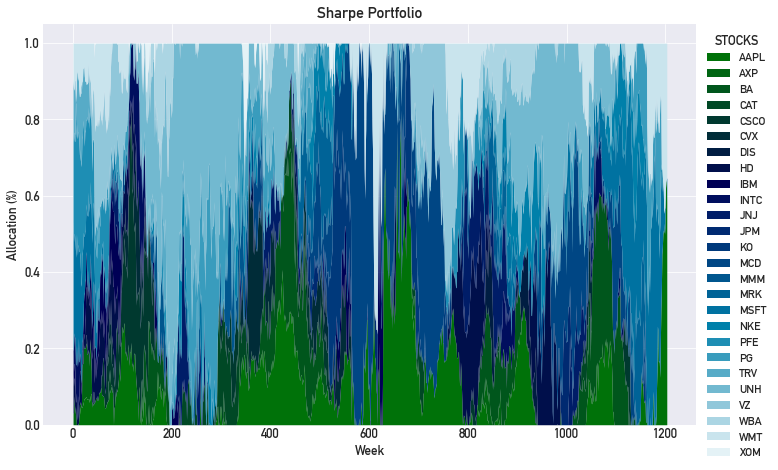

In [79]:
w_df = pd.DataFrame(w_sharpe)
w_df.columns = gross_returns.columns[:-1]
w_df[w_df < 0.0] = 0.0 # remove zeros
w_df.plot.area(
    figsize=(11, 7),
    stacked=True,
    lw=0,
    color=sns.color_palette('ocean', n_colors=n)
)
plt.legend(title='STOCKS', bbox_to_anchor=(1., 1.), fontsize=11.5)
plt.title('Sharpe Portfolio')
plt.ylabel('Allocation (%)')
plt.xlabel('Week')
plt.tight_layout()
plt.savefig('plots_CA4/4d_1.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

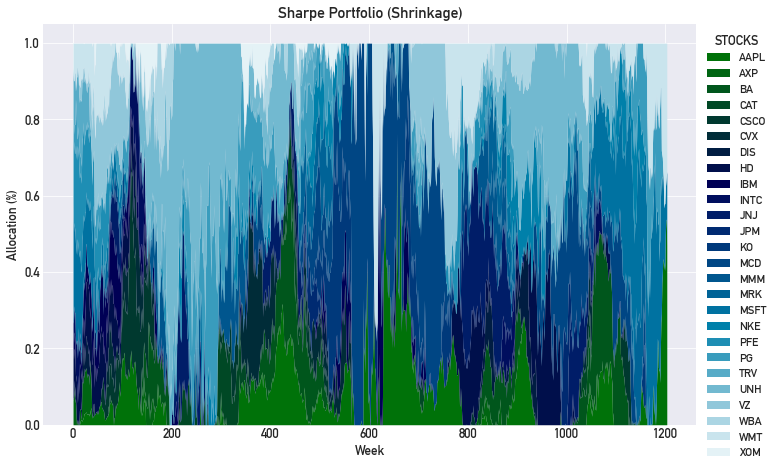

In [80]:
w_df = pd.DataFrame(w_sharpe_s)
w_df.columns = gross_returns.columns[:-1]
w_df[w_df < 0.0] = 0.0 # remove zeros
w_df.plot.area(
    figsize=(11, 7),
    stacked=True,
    lw=0,
    color=sns.color_palette('ocean', n_colors=n)
)
plt.legend(title='STOCKS', bbox_to_anchor=(1., 1.), fontsize=11.5)
plt.title('Sharpe Portfolio (Shrinkage)')
plt.ylabel('Allocation (%)')
plt.xlabel('Week')
plt.tight_layout()
plt.savefig('plots_CA4/4d_2.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

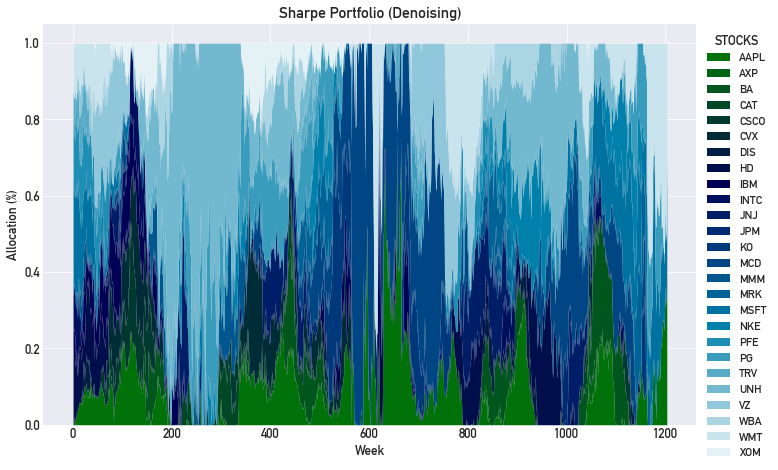

In [81]:
w_df = pd.DataFrame(w_sharpe_d)
w_df.columns = gross_returns.columns[:-1]
w_df[w_df < 0.0] = 0.0 # remove zeros
w_df.plot.area(
    figsize=(11, 7),
    stacked=True,
    lw=0,
    color=sns.color_palette('ocean', n_colors=n)
)
plt.legend(title='STOCKS', bbox_to_anchor=(1., 1.), fontsize=11.5)
plt.title('Sharpe Portfolio (Denoising)')
plt.ylabel('Allocation (%)')
plt.xlabel('Week')
plt.tight_layout()
plt.savefig('plots_CA4/4d_3.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

## Task 5

In [88]:
def risk_parity(w, cov):
    cov_w = cov @ w 
    var = w.T @ cov @ w
    func = w * (cov_w / var) - (1.0 / w.shape[0])
    return np.sum(np.square(func))

In [89]:
def get_allocation_risk_parity(cov):
    init_w = 1.0 / np.sqrt(np.diag(cov))
    res = minimize(
        risk_parity,
        x0=init_w,
        args=(cov),
        method='SLSQP'
    )
    return res.x

In [90]:
def get_allocation_MV_NS(cov, v):
    """ Target portfolio allocation - no shorting """
    n = cov.shape[0]
    w = cvx.Variable(shape=(n, 1), name='w')
    objective_func = cvx.quad_form(w, cov)
    constraints = [
        cvx.sum(w) == v, # fully invested
        w >= 0.0 # no short positions
    ]
    minimize = cvx.Minimize(objective_func)
    problem = cvx.Problem(minimize, constraints)
    problem.solve()
    return w.value

### 5a)

In [91]:
# MV allocation
T = cov_bt.shape[0] - 1
e_MV = np.zeros(T)
ENC_MV = np.zeros(T)
w_MV = np.zeros((T, n))

v = 100.0 # initial investment
for t in np.arange(T):
    w = get_allocation_MV_NS(cov_bt[t], v)
    v = (w.T @ returns_bt[t + 1]).flatten()
    e_MV[t] = v
    ENC_MV[t] = get_ENC(w)
    w_MV[t] = w.flatten() / np.sum(w)

In [92]:
# risk parity allocation
T = cov_bt.shape[0] - 1
e_rp = np.zeros(T)
ENC_rp = np.zeros(T)
w_rp = np.zeros((T, n))

v = 100.0 # initial investment
for t in np.arange(T):
    w = get_allocation_risk_parity(cov_bt[t])
    w = w / np.sum(w) # normalize
    v = v * (w.T @ returns_bt[t + 1]).flatten()
    e_rp[t] = v
    ENC_rp[t] = get_ENC(w)
    w_rp[t] = w.flatten()

In [93]:
# create df for plot
res_5a = {
    'Week': np.arange(T),
    'Minimum variance portfolio': e_MV,
    'Risk parity portfolio': e_rp
}

df_5a = pd.DataFrame(res_5a).set_index('Week')

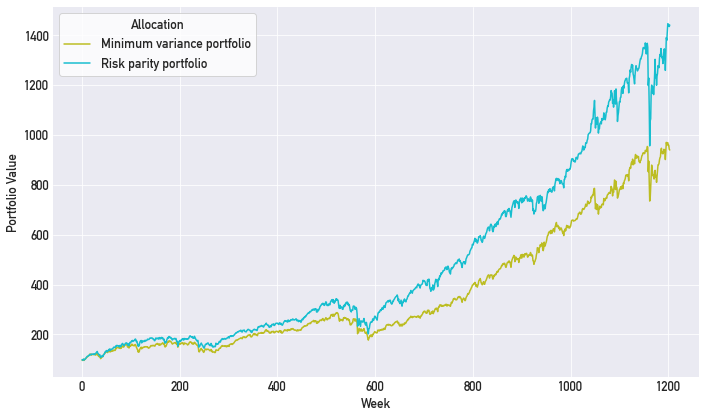

In [94]:
df_5a.plot(figsize=(10, 6), color=sns.color_palette()[8:10])
plt.ylabel('Portfolio Value')
plt.legend(frameon=1, facecolor='white', title='Allocation')
plt.tight_layout()
plt.savefig('plots_CA4/5a.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

### 5b)

In [95]:
idx = df_5a.index % 100 == 0
tab_5b = df_5a.loc[idx].round(2)
tab_5b

,Minimum variance portfolio,Risk parity portfolio
Week,,
0,96.93,98.03
100,155.28,168.99
200,160.84,171.01
300,155.99,190.56
400,211.42,244.80
500,265.31,329.08
600,209.65,272.51
700,292.75,415.65
800,398.39,557.52


In [96]:
# for report use - 5b)
res_5b_latex = tab_5b.to_latex(
    position='H',
    label='tab:5b',
    caption='Caption'
)
print(res_5b_latex)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:5b}
\begin{tabular}{lrr}
\toprule
{} &  Minimum variance portfolio &  Risk parity portfolio \\
Week &                             &                        \\
\midrule
0    &                       96.93 &                  98.03 \\
100  &                      155.28 &                 168.99 \\
200  &                      160.84 &                 171.01 \\
300  &                      155.99 &                 190.56 \\
400  &                      211.42 &                 244.80 \\
500  &                      265.31 &                 329.08 \\
600  &                      209.65 &                 272.51 \\
700  &                      292.75 &                 415.65 \\
800  &                      398.39 &                 557.52 \\
900  &                      505.91 &                 728.01 \\
1000 &                      633.60 &                 871.71 \\
1100 &                      781.21 &                1134.05 \\
1200 &              

### 5c)

In [97]:
# define portfolio lists
portfolio_labels = [
    'Minimum variance portfolio',
    'Risk parity portfolio'
]
portfolios = [e_MV, e_rp]
ENCs = [ENC_MV, ENC_rp]

# create dict and df
res = {
    'Portfolio': portfolio_labels,
    'Mean': [get_annualized_mean(e) for e in portfolios],
    'Volatility': [get_annualized_volatility(e) for e in portfolios],
    'Sharpe Ratio': [get_sharpe(e) for e in portfolios],
    'MDD': [get_MD(e) for e in portfolios],
    'Average ENC': [get_annualized_ENC(ENC) for ENC in ENCs]   
}
df_5c = pd.DataFrame(res).set_index('Portfolio').round(4)

# print results
df_5c

,Mean,Volatility,Sharpe Ratio,MDD,Average ENC
Portfolio,,,,,
Minimum variance portfolio,0.1090,0.1455,0.7493,0.3843,6.3440
Risk parity portfolio,0.1301,0.1655,0.7866,0.4108,24.5915


In [98]:
# for report use - 5c)
caption = 'Caption'
res_5c = df_5c.to_latex(position='H', caption=caption, label='tab:5c')
print(res_5c)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:5c}
\begin{tabular}{lrrrrr}
\toprule
{} &    Mean &  Volatility &  Sharpe Ratio &     MDD &  Average ENC \\
Portfolio                  &         &             &               &         &              \\
\midrule
Minimum variance portfolio &  0.1090 &      0.1455 &        0.7493 &  0.3843 &       6.3440 \\
Risk parity portfolio      &  0.1301 &      0.1655 &        0.7866 &  0.4108 &      24.5915 \\
\bottomrule
\end{tabular}
\end{table}



### 5d)

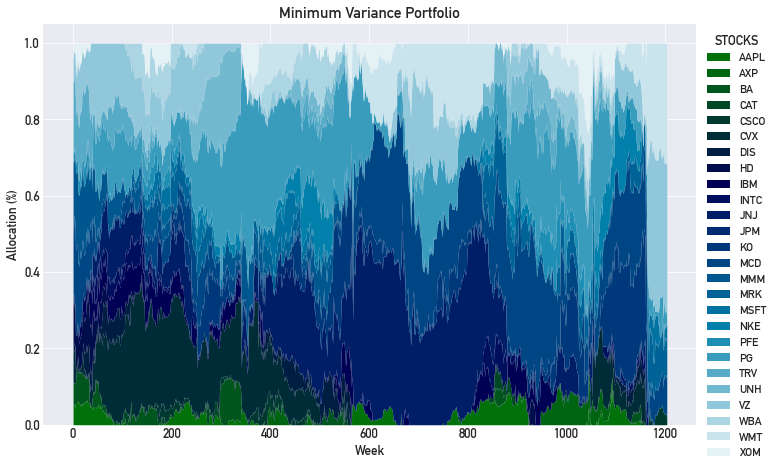

In [99]:
w_df = pd.DataFrame(w_MV)
w_df.columns = gross_returns.columns[:-1]
w_df[w_df < 0.0] = 0.0 # remove zeros
w_df.plot.area(
    figsize=(11, 7),
    stacked=True,
    lw=0,
    color=sns.color_palette('ocean', n_colors=n)
)
plt.legend(title='STOCKS', bbox_to_anchor=(1., 1.), fontsize=11.5)
plt.title('Minimum Variance Portfolio')
plt.ylabel('Allocation (%)')
plt.xlabel('Week')
plt.tight_layout()
plt.savefig('plots_CA4/5d_1.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()

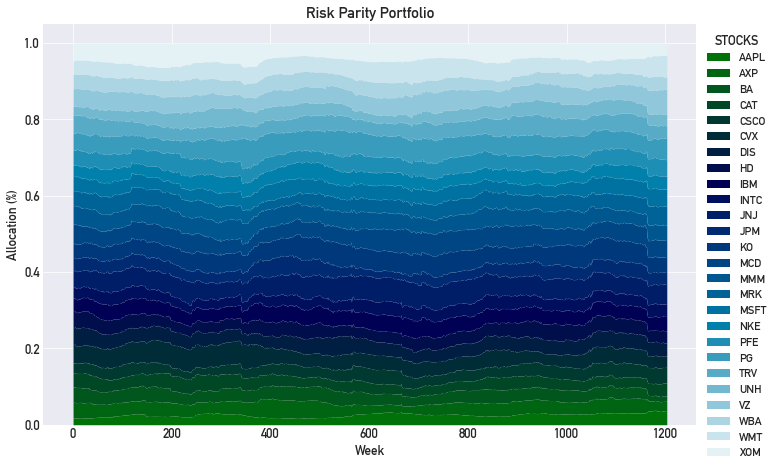

In [100]:
w_df = pd.DataFrame(w_rp.reshape((T, n)))
w_df.columns = gross_returns.columns[:-1]
w_df[w_df < 0.0] = 0.0 # remove zeros
w_df.plot.area(
    figsize=(11, 7),
    stacked=True,
    lw=0,
    color=sns.color_palette('ocean', n_colors=n)
)
plt.legend(title='STOCKS', bbox_to_anchor=(1., 1.), fontsize=11.5)
plt.title('Risk Parity Portfolio')
plt.ylabel('Allocation (%)')
plt.xlabel('Week')
plt.tight_layout()
plt.savefig('plots_CA4/5d_2.png', dpi=plt_dpi, bbox_inches='tight')
plt.show()